# AlphaZero version 16

This AlphaZero version starts from the weights of the net from the first part of Experiment 1 that was trained on 4,000,000 Hard AI samples for one epoch.

* Initial network: AlphaZero-Exp1-2018-10-21-10-15-41 (alphaZero/model/AlphaZero-Exp1-2018-10-21-10-15-41.16.h5)
* Target network: AlphaZero-Exp1-2018-10-21-10-15-41-SP (alphaZero/model/AlphaZero-Exp1-2018-10-21-10-15-41-SP.h5)

In [1]:
import sys
sys.path.append('..')

import numpy as np
import tensorflow as tf
from tensorflow.python import debug as tf_debug

from keras.callbacks import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.initializers import *
from keras.utils.np_utils import to_categorical
from keras.utils import plot_model
import keras.backend as K
from keras.regularizers import l2
from keras.engine.topology import Layer

from PIL import Image
from matplotlib.pyplot import imshow
%matplotlib inline
import random
import gc

from LineFilterLayer import LineFilterLayer
from ValueLayer import ValueLayer
from AugmentationSequence import AugmentationSequence

modelPath = 'model/AlphaZero-Exp1-2018-10-21-10-15-41-SP.h5'
baseModelPath = 'model/AlphaZero-Exp1-2018-10-21-10-15-41.16.h5'

datasetPaths = ['linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-00:35-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-01:36-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-02:37-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-03:37-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-04:38-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-05:39-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-06:42-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-07:44-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-08:45-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-09:43-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-10:42-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-11:40-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-12:41-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-13:40-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-14:39-22_10_2018.npz',
                'linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-23:38-21_10_2018.npz'
               ]

Using TensorFlow backend.


In [2]:
print(K.image_data_format()) 
# expected output: channels_last

channels_last


In [3]:
def dotsAndBoxesToCategorical(inputData):
    inp = np.copy(inputData)
    inp[inp == 255] = 1 # Line - comes first so that target data only has two categories
    inp[inp == 65] = 2 # Box A
    inp[inp == 150] = 3 # Box B
    inp[inp == 215] = 4 # Dot
    cat = to_categorical(inp)
    newShape = inp.shape + (cat.shape[-1],)
    return cat.reshape(newShape)

In [4]:
def imgSizeToBoxes(x):
    return (x-3)/2

def lineFilterMatrixNP(imgWidth,imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=np.bool)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = 1
    return mat


In [5]:
def loadRawPVDataset(datasetPath):
    rawDataset = np.load(datasetPath)
    
    x_input = rawDataset['input']
    y_policy = rawDataset['policy']
    y_value = rawDataset['value']
    
    return (x_input, y_policy, y_value)

def process_input(x_input):
    return dotsAndBoxesToCategorical(x_input)

def process_policy(y_policy):
    y_policy = y_policy[:,lineFilterMatrixNP(y_policy.shape[-1], y_policy.shape[-2])]
    y_policy /= 255
    return y_policy

np.set_printoptions(precision=2)

In [6]:
(x_input_raw, y_policy_raw, y_value_raw) = loadRawPVDataset(datasetPaths[0])

print(x_input_raw.shape)
print(y_policy_raw.shape)
print(y_value_raw.shape)
print("raw input:")
print(x_input_raw[0])
print("raw policy:")
print(y_policy_raw[0])
print('raw value:')
print(y_value_raw[0])

(512, 11, 11)
(512, 11, 11)
(512, 1)
raw input:
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215 255 215   0 215   0]
 [  0 255   0   0   0   0   0   0   0   0   0]
 [  0 215 255 215   0 215 255 215 255 215   0]
 [  0   0   0 255   0 255   0   0   0   0   0]
 [  0 215   0 215   0 215   0 215 255 215   0]
 [  0 255   0   0   0 255   0   0   0   0   0]
 [  0 215 255 215 255 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
raw policy:
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 255   0]

In [7]:
imgWidth = x_input_raw.shape[-1]
imgHeight = x_input_raw.shape[-2]
# LineFilterLayer has to be set before loading the model
LineFilterLayer.imgWidth = imgWidth
LineFilterLayer.imgHeight = imgHeight
# ValueLayer has to be set before loading the model
ValueLayer.imgWidth = imgWidth
ValueLayer.imgHeight = imgHeight

model = load_model(baseModelPath,
                   custom_objects={'LineFilterLayer':LineFilterLayer,
                   'ValueLayer':ValueLayer})

model.summary()

LineFilterLayer with image size 11 x 11
ValueLayer with image size 11 x 11
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 5 0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, None, None, 2 11776       input_1[0][0]                    
__________________________________________________________________________________________________
input_relu (Activation)         (None, None, None, 2 0           input_conv[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 2 1024        input_relu[0][0]                 
__________________________________

In [8]:
for datasetPath in datasetPaths:
    print("training on " + datasetPath)
    (x_input_raw, y_policy_raw, y_value_raw) = loadRawPVDataset(datasetPath)
    batch_size = 16
    data_generator = AugmentationSequence(x_input_raw, y_policy_raw, y_value_raw, batch_size, process_input, process_policy)
    model.fit_generator(data_generator, epochs=4, steps_per_epoch=len(data_generator))

model.save(modelPath)

training on linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-00:35-22_10_2018.npz
Epoch 1/4
32/32 [==============================] - 14s 446ms/step - loss: 2.3780 - policy_loss: 2.3019 - value_loss: 0.0479
Epoch 2/4
32/32 [==============================] - 6s 174ms/step - loss: 1.9587 - policy_loss: 1.8961 - value_loss: 0.0339
Epoch 3/4
32/32 [==============================] - 6s 174ms/step - loss: 1.8427 - policy_loss: 1.7856 - value_loss: 0.0281
Epoch 4/4
32/32 [==============================] - 6s 174ms/step - loss: 1.8392 - policy_loss: 1.7840 - value_loss: 0.0259
training on linked_data/StageFour-AlphaZero-Exp1-2018-10-21-10-15-41AlphaZero-it800-dir0.03-c:4-512-4x4-sig0.2-mean0.6-01:36-22_10_2018.npz
Epoch 1/4
32/32 [==============================] - 6s 174ms/step - loss: 1.9050 - policy_loss: 1.8542 - value_loss: 0.0216
Epoch 2/4
32/32 [==============================] - 6s 174ms/step - loss: 1.8735 - policy_loss: 1.8236 - 

In [9]:
def linesToDotsAndBoxesImage(lines, imgWidth, imgHeight):
    boxWidth = imgSizeToBoxes(imgWidth)
    boxHeight = imgSizeToBoxes(imgHeight)
    linesCnt = 2*boxWidth*boxHeight+boxWidth+boxHeight
    mat = np.zeros((imgHeight, imgWidth), dtype=lines.dtype)
    for idx in range(linesCnt):
        y1 = idx / ((2*boxWidth) + 1)
        if idx % ((2*boxWidth) + 1) < boxWidth:
            # horizontal line
            x1 = idx % ((2*boxWidth) + 1)
            x2 = x1 + 1
            y2 = y1
        else:
            # vertical line
            x1 = idx % ((2*boxWidth) + 1) - boxWidth
            x2 = x1
            y2 = y1 + 1
        px = x2 * 2 + y2 - y1
        py = y2 * 2 + x2 - x1
        mat[py,px] = lines[idx]
    return mat

example: 157
[[2 0 3 0 6 6 6 0 0 0 6 0 0 0 1 1 1 0 0 0 0 8 5 6 7 5 0 0 6 1 5 1 1 0 0 5
  0 5 1 1]]
0.9999999
input (11, 11): 
[[  0   0   0   0   0   0   0   0   0   0   0]
 [  0 215   0 215 255 215   0 215 255 215   0]
 [  0   0   0   0   0   0   0   0   0 255   0]
 [  0 215 255 215   0 215 255 215   0 215   0]
 [  0 255   0   0   0   0   0   0   0 255   0]
 [  0 215   0 215 255 215 255 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0 255   0]
 [  0 215 255 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0 255   0 255   0   0   0]
 [  0 215 255 215   0 215   0 215   0 215   0]
 [  0   0   0   0   0   0   0   0   0   0   0]]
prediction policy: 
[[0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 3 0 0 0 0]
 [0 6 0 6 0 6 0 0 0 0 0]
 [0 0 0 0 6 0 0 0 0 0 0]
 [0 0 0 1 0 1 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 8 0 0]
 [0 5 0 6 0 7 0 5 0 0 0]
 [0 0 0 0 6 0 1 0 5 0 0]
 [0 1 0 1 0 0 0 0 0 5 0]
 [0 0 0 0 5 0 1 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0]]
prediction value: 
[[-0.08]]
target value: 
[-0.02]


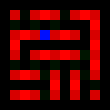

In [10]:
example = random.randrange(x_input_raw.shape[0])
print("example: "+str(example))

input_data = process_input(x_input_raw[example:example+1])

(prediction_lines, prediction_value) = model.predict(input_data)
prediction_lines_print = prediction_lines * 100
print(prediction_lines_print.astype(np.uint8))
print(np.sum(prediction_lines))
prediction = linesToDotsAndBoxesImage(prediction_lines[0], imgWidth, imgHeight)

# print input data
input_data_print = x_input_raw[example]
print("input "+str(input_data_print.shape)+": ")
print(input_data_print)

# generate greyscale image data from input data
input_imgdata = x_input_raw[example]

# print prediction
prediction_data_print = prediction * 100 
prediction_data_print = prediction_data_print.astype(np.uint8)
print("prediction policy: ")
print(prediction_data_print)

print("prediction value: ")
print(prediction_value)

print("target value: ")
print(y_value_raw[example])

# generate greyscale image data from prediction data
prediction_imgdata = prediction * 255
prediction_imgdata = prediction_imgdata.astype(np.uint8)

# generate greyscale image of target data
target_imgdata = y_policy_raw[example]

# merge image data in color channels
merged_imgdata = np.stack([input_imgdata, prediction_imgdata, target_imgdata], axis=2)

#create image
img = Image.fromarray(merged_imgdata, 'RGB')
img = img.resize(size=(img.size[0]*10, img.size[1]*10))

img